In [29]:
!rm -rf /content/__MACOSX

In [ ]:
!rm -rf /content/cars_data

In [ ]:
!unzip "/content/cars_data.zip"

In [1]:
folder = "/content/cars_data"

In [ ]:
!zip -r samples.zip /content/samples

In [ ]:
!zip -r car_data_new.zip /content/cars_data

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHt9-CHATSIsVJ7PqJoulIhL_l6O2wBgdoUF48vsL7ExxInjdJVmFQ
Mounted at /content/drive


In [44]:
!cp /content/car_data_new.zip /content/drive/'My Drive'

In [1]:
!rm -rf /content/samples

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
folder = "/content/cars_data"

In [7]:
for filename in os.listdir(folder):
    img = Image.open(os.path.join(folder,filename)).convert('RGB')
    img.save(os.path.join(folder,filename)) 
    

In [8]:
IMAGE_DIM = (32, 32, 3)

In [9]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [10]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # 
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [11]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [12]:
class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpeg')))
        #gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        #for num in gray_lst:
        #    self.fpaths.remove(os.path.join(data_path, '{:05d}.png'.format(num)))
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [13]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [14]:

transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [15]:
dataset = CARS(data_path='/content/cars_data/', transform=transform)

In [16]:
batch_size = 64

In [17]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [22]:
max_epoch = 2200
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [23]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [21]:
!mkdir samples

In [24]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/2200, Step: 0, D Loss: 1.3951, G Loss: 0.7163, Time:18:38:10
Epoch: 55/2200, Step: 500, D Loss: 0.8883, G Loss: 1.5214, Time:18:39:38
Epoch: 111/2200, Step: 1000, D Loss: 0.7377, G Loss: 2.2642, Time:18:41:08
Epoch: 166/2200, Step: 1500, D Loss: 0.4964, G Loss: 3.1451, Time:18:42:37
Epoch: 222/2200, Step: 2000, D Loss: 0.3691, G Loss: 3.3335, Time:18:44:07
Epoch: 277/2200, Step: 2500, D Loss: 0.3819, G Loss: 5.1033, Time:18:45:37
Epoch: 333/2200, Step: 3000, D Loss: 0.0846, G Loss: 3.6961, Time:18:47:07
Epoch: 388/2200, Step: 3500, D Loss: 0.1358, G Loss: 4.9617, Time:18:48:38
Epoch: 444/2200, Step: 4000, D Loss: 0.2558, G Loss: 4.5639, Time:18:50:10
Epoch: 500/2200, Step: 4500, D Loss: 0.0799, G Loss: 6.1399, Time:18:51:42
Epoch: 555/2200, Step: 5000, D Loss: 0.2742, G Loss: 6.5838, Time:18:53:13
Epoch: 611/2200, Step: 5500, D Loss: 0.0364, G Loss: 5.6401, Time:18:54:45
Epoch: 666/2200, Step: 6000, D Loss: 0.2710, G Loss: 6.2030, Time:18:56:14
Epoch: 722/2200, Step: 6500, D L

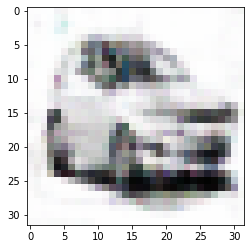

In [38]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

In [ ]:
# Real Image
#t = Image.open(dataset.fpaths[999])
#t = (transform(t).permute(1, 2, 0)+1)/2.
#imshow(t)

In [39]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [40]:

# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'dcgan.pth.tar')